Learning Rate: 0.001
Epoch [1/100], Train Loss: 0.04654568104539067, Val Loss: 0.007087105436117521
Learning Rate: 0.001
Epoch [2/100], Train Loss: 0.0036430182703770697, Val Loss: 0.0068091896495648795
Learning Rate: 0.001
Epoch [3/100], Train Loss: 0.0022961393976584075, Val Loss: 0.006481406877615622
Learning Rate: 0.001
Epoch [4/100], Train Loss: 0.003386161358212121, Val Loss: 0.0031334265950135887
Learning Rate: 0.001
Epoch [5/100], Train Loss: 0.0017236570676323027, Val Loss: 0.0031119510281964074
Learning Rate: 0.001
Epoch [6/100], Train Loss: 0.002053913384443149, Val Loss: 0.003173713447137873
Learning Rate: 0.001
Epoch [7/100], Train Loss: 0.0014112910267431288, Val Loss: 0.0030847988756639616
Learning Rate: 0.001
Epoch [8/100], Train Loss: 0.0017664890317246318, Val Loss: 0.00908531085588038
Learning Rate: 0.001
Epoch [9/100], Train Loss: 0.001716784759191796, Val Loss: 0.0034982632496394217
Learning Rate: 0.001
Epoch [10/100], Train Loss: 0.0012003256412572228, Val Loss: 0

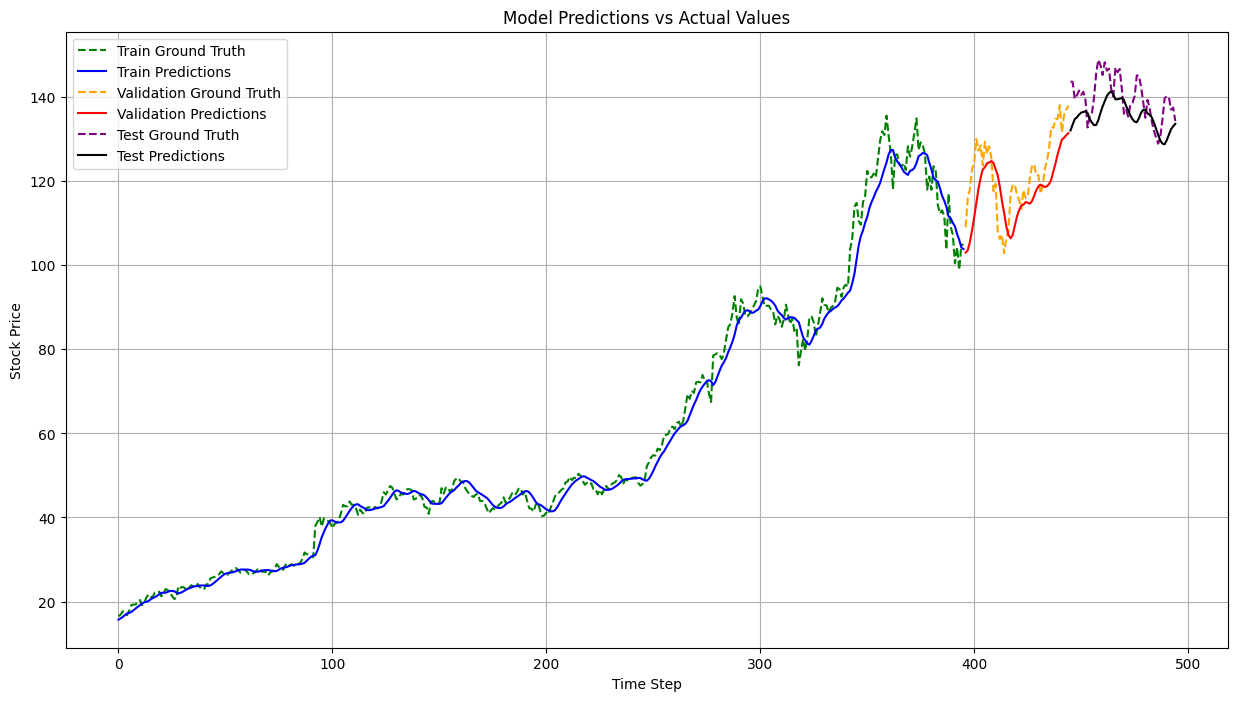

In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Hyperparameters
input_len = 7   # Length of input sequences
output_len = 1  # Length of output sequence
batch_size = 8
epochs = 100
learning_rate = 0.001  # Lowered learning rate for stability

# 1. Load data
def load_data(csv_path):
    df = pd.read_csv(csv_path)  # Default is comma-separated
    df.columns = df.columns.str.strip()  # Strip any extra whitespace or hidden characters
    # print("Columns found:", df.columns.tolist())

    # Check for missing values
    if df["Close"].isnull().sum() > 0:
        print(f"Warning: There are {df['Close'].isnull().sum()} missing values in the 'Close' column.")
    
    prices = df["Close"].values.reshape(-1, 1)  # Get the 'Close' price column
    # Initialize the MinMaxScaler (normalized between 0 and 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    # Fit the scaler on the price data (normalize it)
    prices_scaled = scaler.fit_transform(prices)
    return prices_scaled, scaler

# 2. Create sequences for LSTM
def create_sequences(data, input_len, output_len):
    X, y = [], []
    for i in range(len(data) - input_len - output_len + 1):
        X.append(data[i:i + input_len])  # Input sequence
        y.append(data[i + input_len:i + input_len + output_len])  # Output sequence
    return np.array(X), np.array(y)

# 3. Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=128, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=2, batch_first=True)  # Two LSTM layers
        self.dropout = nn.Dropout(0.2)  # Dropout for regularization
        self.fc = nn.Linear(hidden_layer_size, output_size)
        
    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        lstm_out = self.dropout(lstm_out)  # Apply dropout
        predictions = self.fc(lstm_out[:, -1])
        return predictions

# 4. Training the model with Early Stopping
def train_model(model, train_loader, val_loader, epochs, criterion, optimizer, scheduler, patience=10):
    best_val_loss = float('inf')  # Initialize the best validation loss
    patience_counter = 0  # Counter to track how many epochs since the last improvement in validation loss
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        # Step the learning rate scheduler
        scheduler.step(val_loss)
        # Get and print the current learning rate
        print(f"Learning Rate: {scheduler.get_last_lr()[0]}")

        # Print loss for this epoch
        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {running_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}")

        # Check if the validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset the counter if validation loss improves
            # Save the best model weights
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1

        # Check if early stopping should be triggered
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

# 5. Plot predictions vs ground truths (combined continuous with different colors)
def plot_predictions(train_preds, val_preds, test_preds, y_train, y_val, y_test):
    # Flatten the target values to match the prediction shapes
    y_train = y_train.flatten()
    y_val = y_val.flatten()
    y_test = y_test.flatten()

    # Ensure that predictions are correctly flattened
    train_preds = train_preds.flatten()
    val_preds = val_preds.flatten()
    test_preds = test_preds.flatten()

    # Plot combined predictions vs ground truths with different colors
    plt.figure(figsize=(15, 8))

    # Plot training data
    plt.plot(np.arange(len(y_train)), y_train, label="Train Ground Truth", linestyle='--', color='green')
    plt.plot(np.arange(len(train_preds)), train_preds, label="Train Predictions", linestyle='-', color='blue')

    # Plot validation data
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, label="Validation Ground Truth", linestyle='--', color='orange')
    plt.plot(np.arange(len(train_preds), len(train_preds) + len(val_preds)), val_preds, label="Validation Predictions", linestyle='-', color='red')

    # Plot test data
    plt.plot(np.arange(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test)), y_test, label="Test Ground Truth", linestyle='--', color='purple')
    plt.plot(np.arange(len(train_preds) + len(val_preds), len(train_preds) + len(val_preds) + len(test_preds)), test_preds, label="Test Predictions", linestyle='-', color='black')

    plt.legend()
    plt.title('Model Predictions vs Actual Values')
    plt.xlabel('Time Step')
    plt.ylabel('Stock Price')
    plt.grid(True)
    plt.show()

# Main function
def main(csv_path):
    # Load and prepare data
    data, scaler = load_data(csv_path)
    
    # Create sequences for LSTM
    X, y = create_sequences(data, input_len, output_len)
    
    # Split into train, validation, and test sets (8:1:1 ratio)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
    
    # Convert to tensors (no need to rescale again)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    # Create DataLoader for batching
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate model, criterion, and optimizer
    model = LSTMModel()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

    # Train the model
    train_model(model, train_loader, val_loader, epochs, criterion, optimizer, scheduler, patience=10)

    # Evaluate the model on the test set
    model.eval()
    test_loss = 0.0
    test_preds = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            test_preds.append(outputs.numpy())
    
    print(f"Test Loss: {test_loss / len(test_loader)}")

    # Predictions for train and validation sets
    model.eval()
    train_preds = []
    val_preds = []
    with torch.no_grad():
        for inputs, _ in train_loader:
            outputs = model(inputs)
            train_preds.append(outputs.numpy())
        for inputs, _ in val_loader:
            outputs = model(inputs)
            val_preds.append(outputs.numpy())
    
    # Flatten predictions
    train_preds = np.concatenate(train_preds)
    val_preds = np.concatenate(val_preds)
    test_preds = np.concatenate(test_preds)

    # Step 1: Make predictions (scaled)
    train_preds = model(X_train_tensor)  # Predicted prices (scaled)

    # Step 2: Inverse transform to get the original scale
    train_preds = scaler.inverse_transform(train_preds.detach().numpy().reshape(-1, 1))  # Reshape for inverse_transform

    # Inverse transform the predictions and ground truth values
    val_preds = scaler.inverse_transform(val_preds.reshape(-1, 1))  # Reshape to 2D
    test_preds = scaler.inverse_transform(test_preds.reshape(-1, 1))  # Reshape to 2D
    y_train = scaler.inverse_transform(y_train.reshape(-1, 1))  # Reshape to 2D
    y_val = scaler.inverse_transform(y_val.reshape(-1, 1))  # Reshape to 2D
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))  # Reshape to 2D

    # Plot predictions vs ground truths
    plot_predictions(train_preds, val_preds, test_preds, y_train, y_val, y_test)

# Run the pipeline
if __name__ == "__main__":
    main("nvda_stock_data_2.csv")  # Replace with your file path